In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
import pickle
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
vgg_19 = torchvision.models.vgg19_bn(pretrained=True)
vgg_19.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

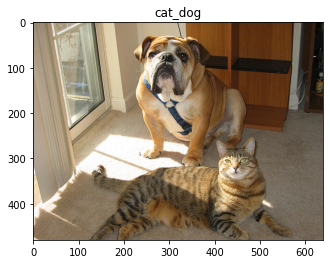

In [4]:
cat_dog = Image.open('../data/cat_dog.jpg')
%matplotlib inline
import matplotlib.pyplot as plt 
plt.imshow(cat_dog)
plt.axis('on') # 关掉坐标轴为 off
plt.title('cat_dog') # 图像题目
plt.show()

# cat_dog = (np.array(cat_dog)/255.).astype(np.float32)
# torchvision.io.read_image('/Users/yang/PycharmProjects/grad-cam/images/cat_dog.jpg')
# cat_dog.transpose(2,0,1).shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


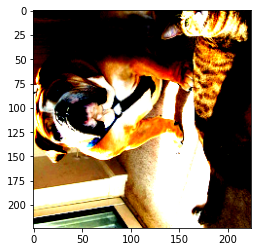

In [7]:
transform = transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(), # 将图片转换为Tensor,归一化至[0,1]
 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
output_softmax = nn.Softmax(dim=1)
cat_dog_ten = transform(cat_dog).unsqueeze(0)

cat_dog_ten.shape
plt.imshow(cat_dog_ten.squeeze().transpose(2,0))


In [8]:
vgg_19.eval()
loss = nn.CrossEntropyLoss()

# x = cat_dog_ten
input_im = Variable(cat_dog_ten.clone(), requires_grad=True)

x = vgg_19.features[0](input_im)

for i in range(1, 50):
    x = vgg_19.features[i](x)
    
# conv_out = Variable(x, requires_grad=True)
conv_out = x
x = vgg_19.features[50](conv_out)
x = vgg_19.features[51](x)
x = vgg_19.features[52](x)

# conv_out = Variable(x.clone(), requires_grad=True)

x = vgg_19.avgpool(x)
x = torch.flatten(x, 1)
output = vgg_19.classifier(x)

# output = vgg_19(cat_dog_ten)

In [9]:
outsoft = output_softmax(output)
outsoft.shape
print(torch.max(output, dim=1))
vgg_19.zero_grad()
# conv_out.zero_grad()

# torch.max(output, dim=1)[0].backward(retain_graph=True)

torch.max(output, dim=1)[0].backward()

torch.return_types.max(
values=tensor([13.9669], grad_fn=<MaxBackward0>),
indices=tensor([243]))


In [42]:
# conv_out_grad = conv_out.grad
input_grad = input_im.grad
print(conv_out_grad.shape, input_grad.shape)

torch.Size([1, 512, 14, 14]) torch.Size([1, 3, 224, 224])


In [43]:
im_grad

tensor([[0.0125, 0.0000, 0.0004,  ..., 0.0000, 0.0125, 0.0000],
        [0.0060, 0.0166, 0.0206,  ..., 0.0034, 0.0070, 0.0000],
        [0.0157, 0.0106, 0.0071,  ..., 0.0173, 0.0000, 0.0008],
        ...,
        [0.0000, 0.0020, 0.0145,  ..., 0.0107, 0.0180, 0.0225],
        [0.0000, 0.0000, 0.0000,  ..., 0.0220, 0.0179, 0.0008],
        [0.0048, 0.0000, 0.0062,  ..., 0.0000, 0.0068, 0.0000]])

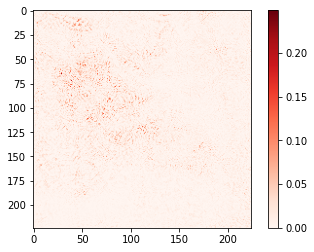

In [44]:
im_grad = input_grad[0].transpose(0,2)
im_grad = im_grad.clamp_min(0).mean(dim=2)

im = plt.imshow(im_grad, cmap='Reds')
plt.colorbar(im)

In [9]:
# def forward(self, x):
#     x = self.features(x)
#     x = self.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.classifier(x)
#     return x

# vgg_19.zero_grad()
conv_out_grad_weight = conv_out_grad.sum(dim=(2,3), keepdim=True)
conv_out_grad_mul_weight = conv_out_grad * conv_out_grad_weight

Max and min is tensor(0.0062) tensor(0.0007)


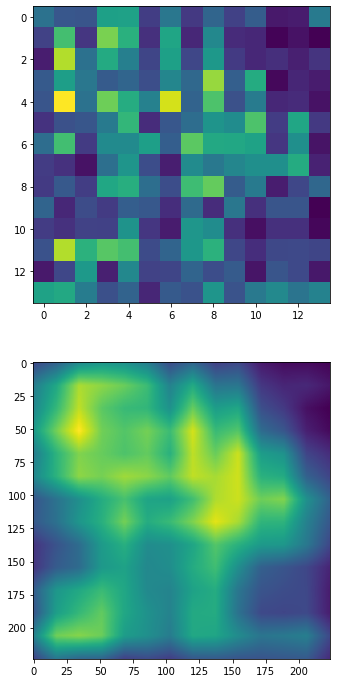

In [11]:
# vgg_19.features
avg_pool = nn.AvgPool2d(kernel_size=(3,3), stride=1, padding=1)

conv_out_grad_gap_relu = torch.nn.functional.relu(conv_out_grad_mul_weight.mean(dim=1, keepdim=True))
conv_out_grad_gap_relu_avg = avg_pool(conv_out_grad_gap_relu)

plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
_ = ax.imshow(conv_out_grad_gap_relu.squeeze().numpy())
upsample = nn.UpsamplingBilinear2d(size=(224,224))
conv_out_grad_gap_relu_up = upsample(conv_out_grad_gap_relu_avg)

# plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 2)

_ = ax.imshow(conv_out_grad_gap_relu_up.squeeze().numpy())
print('Max and min is', conv_out_grad_gap_relu_up.max(), conv_out_grad_gap_relu_up.min())

torch.Size([224, 224, 3]) torch.Size([224, 224])


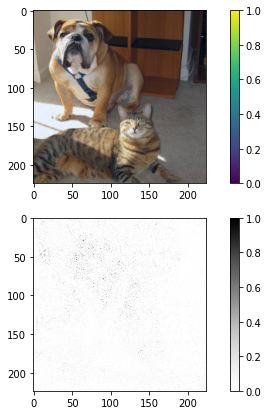

In [58]:
pdf = PdfPages('input_cam_im.pdf')

plt.figure(figsize=(8.5, 7))

ax = plt.subplot(2, 1, 1)
# im = plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))
input_im = cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)
# input_im -= input_im.min()
# input_im /= input_im.max()
im = plt.imshow(input_im)

plt.colorbar(im)
ax = plt.subplot(2, 1, 2)
# im = plt.imshow((conv_out_grad_gap_relu_up.squeeze().numpy()-0.0006) /0.0053, cmap='Reds')
# plt.colorbar(im)

input_im_grad = im_grad.transpose(0,1)/im_grad.max()
im = plt.imshow(input_im_grad, cmap='Greys')
plt.colorbar(im)

filename = 'im_grad.pickle'

with open(filename, 'wb') as f:
    pickle.dump({"input_im":input_im.numpy(), "input_im_grad":input_im_grad.numpy(),}, f)

pdf.savefig()
pdf.close()

print(input_im.shape, input_im_grad.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max and min is  tensor(2.6400) tensor(-1.8610)


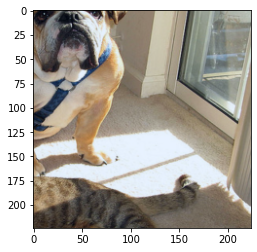

In [32]:
plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))

print('Max and min is ', cat_dog_ten.squeeze().max(), cat_dog_ten.squeeze().min())